<h1><center><strong>Predicting Surface Roughness</strong></center></h1>

## Project Overview

The primary goal is to develop a predictive model that can identify optimal machining parameters to achieve desired Surface Roughness, reducing manufacturing scrap and optimazing production.


## Problem Statement & Motivation

Achieving desired roughness often requires a lot of experimentation which are time-consuming and costly.

The motivation behind this project is to leverage data-driven approaches to `Reduce Iterations`,`Improve Efficiency`, `Quality Control` , `Cost Savings`  by reducing/eliminating the need for test runs to find optimal parameters,  proactively identify parameters that lead to desired surface finishes thereby lowering scrap and reducing machining time.


## Dataset information

Made in the [COMPETENCE CENTER IN MANUFACTURING (CCM)](https://www.ccm.ita.br/), a laboratory of the [AERONAUTICS INSTITUTE OF TECHNOLOGY (ITA)](http://www.ita.br/)

Each row represents a machining run, with columns including:


    depth of cut (ap)
    cutting speed (vc)
    feed rate (f)
    arithmetic mean deviation (Ra)
    skewness (Rsk)
    kurtosis (Rku)
    mean width of profile elements (RSm)
    total height (Rt)
    cutting force (Fc)
    passive force (Fy)
    feed force (Fz)
    resultant force (F)
    tool condition (flank wear width) (TCond)


The dataset size is 612 records, containing 13 features. Data source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)




## Material and equipment

    Material: AISI H13 (mean hardness = 200 HV).
    Machine tool (CNC turning center): ROMI E280 (max rotation = 4k rpm, nominal power = 18.5 kW).
    Cutting tool: SandvikCoromant ISO TNMG 16 04 04-PF 4425; tool shank (holder): ISO MTJNL 2020K 16M1.
    Cutting fluid: a mixture of Blaser Swisslube Vasco 7000 with water in 8%. The acidity (pH) of the mixture was around 8.
    Roughness assessment: Mitutoyo portable roughness tester model Surftest SJ-210.
    Tool wear assessment: digital microscope Dino-Lite model AM4113ZT.
    Forces measurement: dynamometer Kistler Type 9265B, connected to a charge amplifier Kistler Type 5070 and an acquisition software Kistler Dynoware Type 2825A; one computer, and peripherical item: a highly insulated cable, Peripherical Component Interconnect (PCI interface), connection cable, and acquisition plate (A/D).


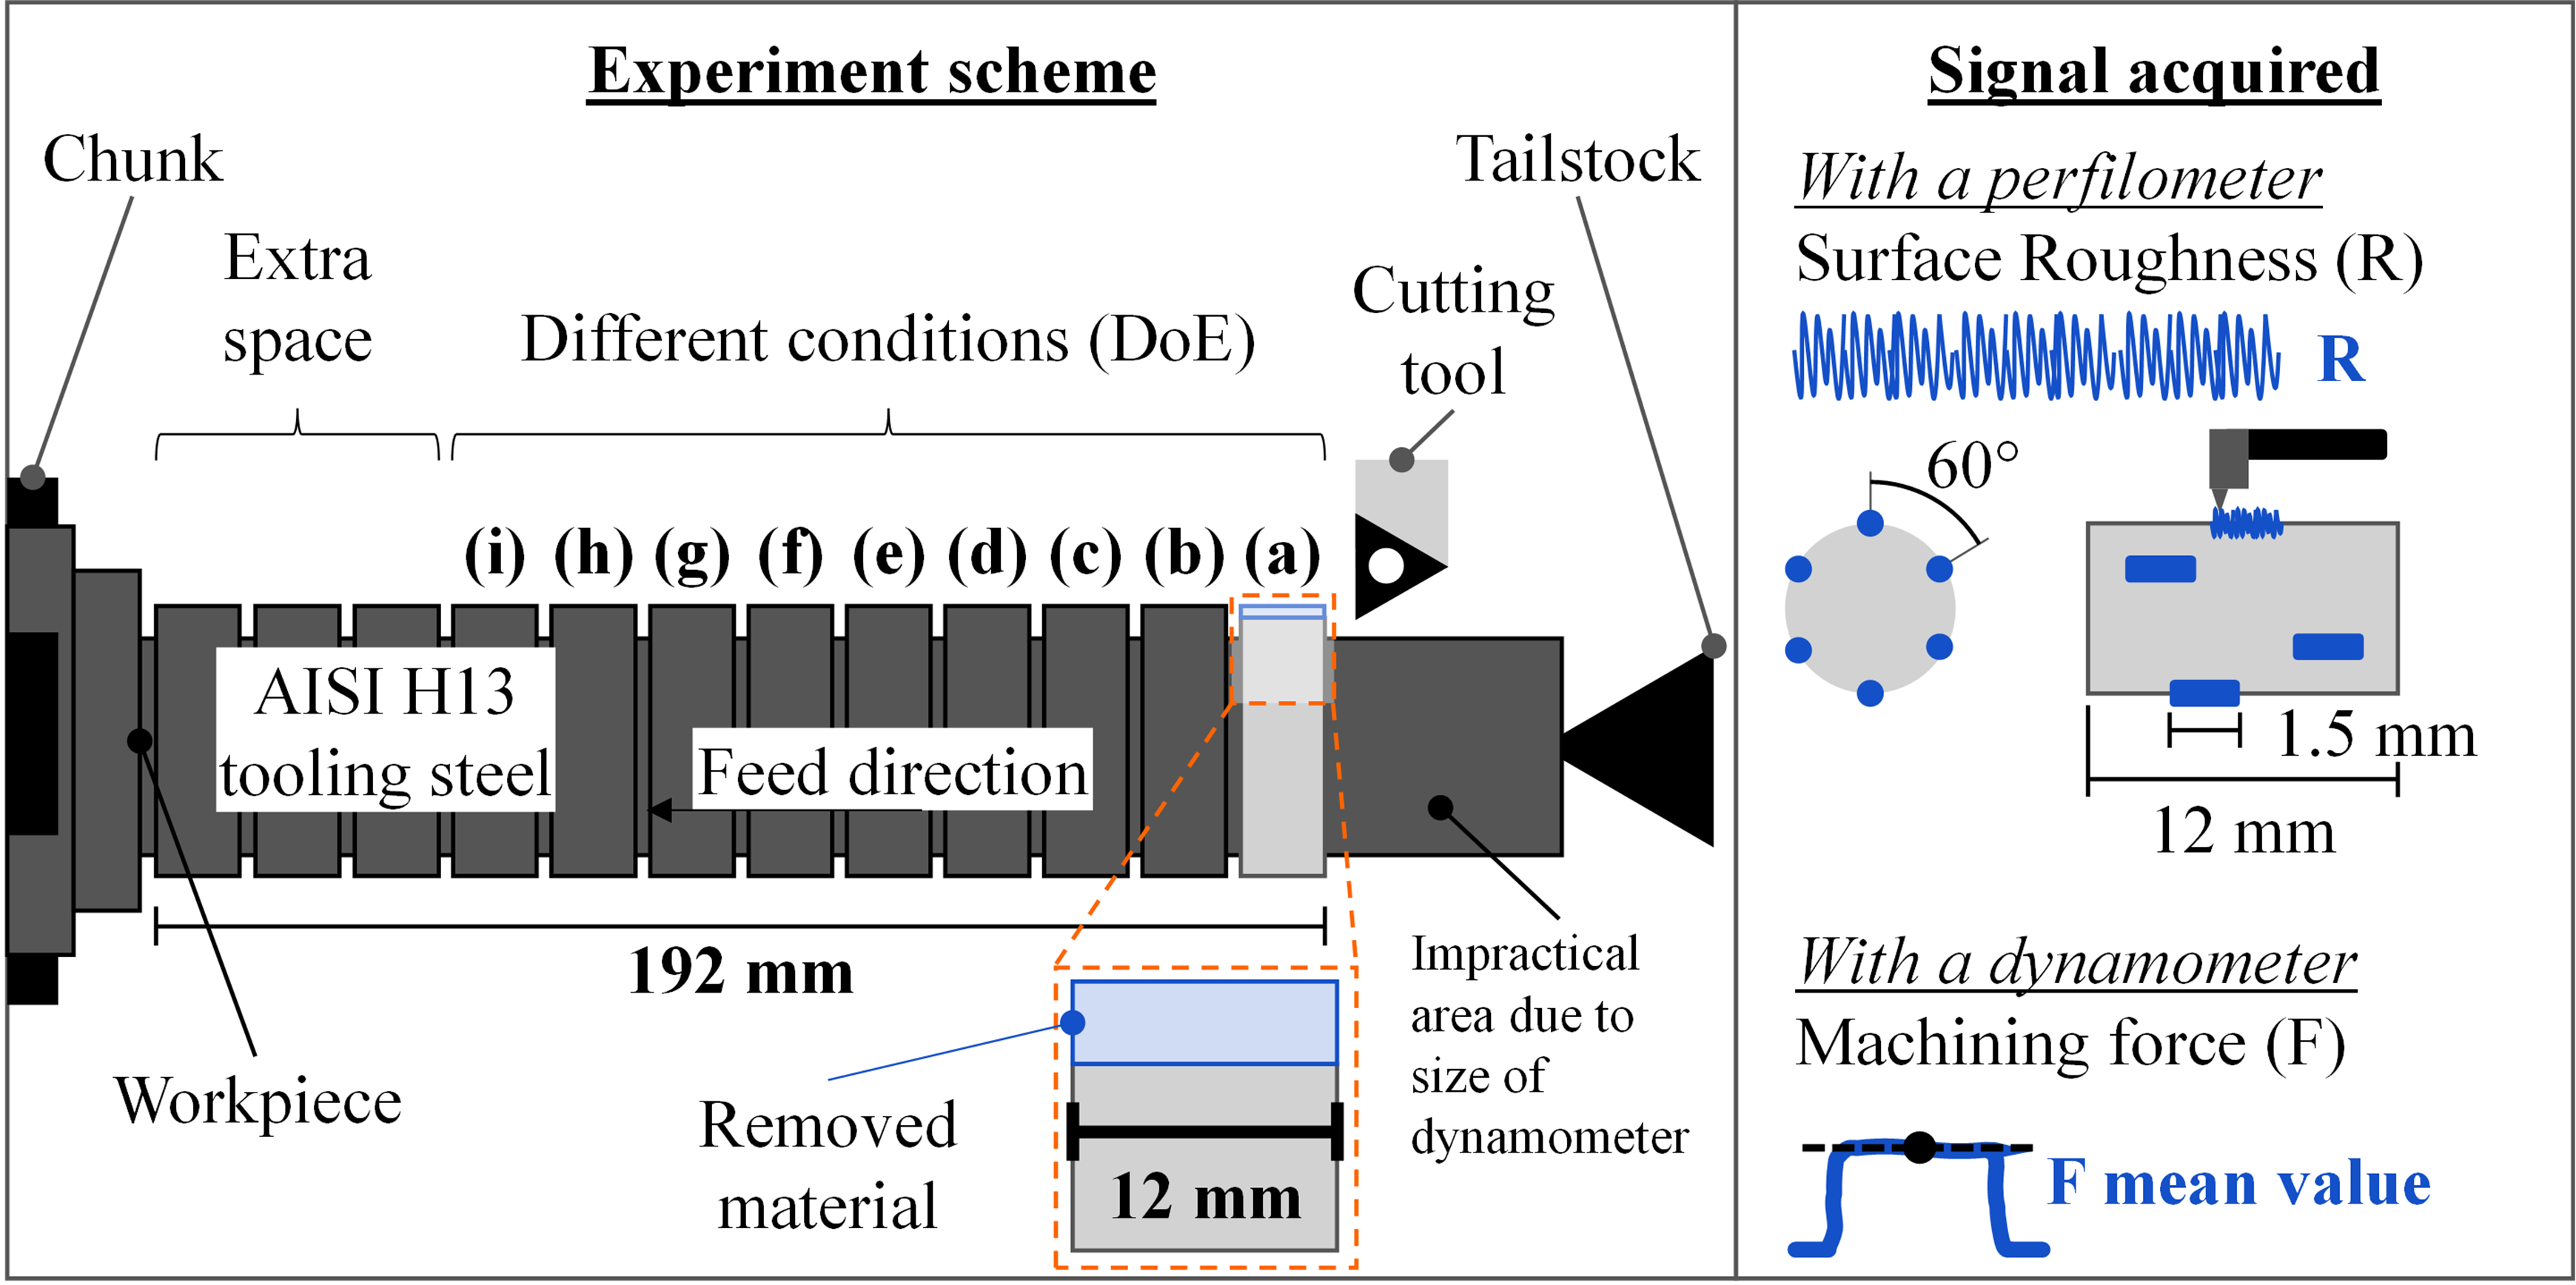

In [105]:
from IPython.display import Image
base_dir = r"E:\Data\CNC\Surface_Roughness"
Image(filename=f"{base_dir}\images\VWjzBJl.png")


<h2><strong>Predicting Surface Roughness (Ra): Data Loading & Exploratory Data Analysis</strong></h2>

This section focuses on loading the raw CNC machining dataset, performing initial data quality checks, and conducting exploratory data analysis to understand the relationships between machining parameters and surface roughness.


## Notebook Objective

This specific notebook focuses on:
1.  **Data Acquisition:** Load dataset.
2.  **Initial Data Inspection:** Perform checks for data quality, missing values, and duplicates.
3.  **Exploratory Data Analysis (EDA):** Examine data through visualizations and statistical summaries to understand:
    * The distribution of the target variable (`Ra`).
    * The distributions of input machining parameters.
    * The relationships between input parameters and `Ra`.
    * Overall data patterns and potential insights for feature engineering and modeling.

### Setup & Imports 

In [106]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from IPython.display import Image, HTML, display, Markdown
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error
import warnings
from scipy.optimize import minimize

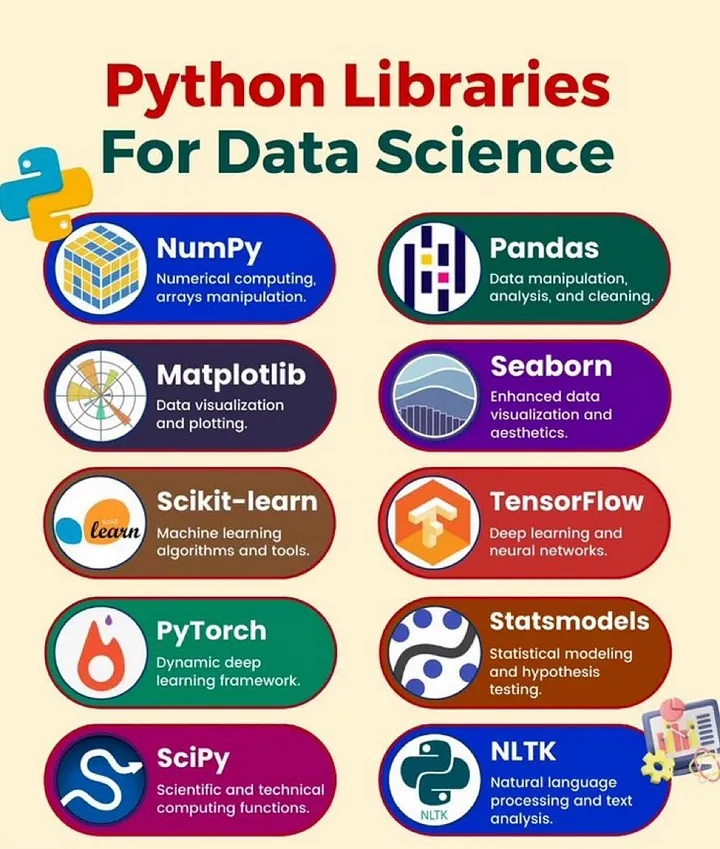

In [107]:
display(Image(filename=rf"{base_dir}\images\libraries.jpg", width=500))

### Data Loading

source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)

In [108]:
base_dir = r"E:\Data\CNC\Surface_Roughness"

file_paths = [f"{base_dir}/data/raw/Exp1.csv",
              f"{base_dir}/data/raw/Exp2.csv"]

# Load Data
df_list = []
for path in file_paths:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            print(f"Data loaded successfully from: {path}")
            print(f"dataset shape: {df.shape}")
            df_list.append(df)
        except Exception as e:
            print(f"Found '{path}' but failed to load")
            continue

# File was not Found
if df is None:
    print("Error: data files were found.")
    print("Place dataset in the appropriate directory.")

# Merge into a single DataFrame
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
else:
    print("No data loaded. Please check file formats or paths.")

Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp1.csv
dataset shape: (324, 27)
Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp2.csv
dataset shape: (288, 27)

Merged DataFrame shape: (612, 27)


In [109]:
merged_df.head()

,Run_ID,Experiment,Replica,Tool_ID,Group,Subgroup,Position,Condition,TCond,Machined_length,Init_diameter,Final_diameter,CTime,R_measurement,ap,vc,f,Ra,Rz,Rsk,Rku,RSm,Rt,Fx,Fy,Fz,F
0,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,94.0,93.5,na,1,0.25,350,0.07,0.391,1.855,0.560,2.423,71.4,2.082,49.23,44.46,21.07,69.600499
1,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,94.0,93.5,na,2,0.25,350,0.07,0.359,1.670,0.530,2.229,70.9,1.918,49.23,44.46,21.07,69.600499
2,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,94.0,93.5,na,3,0.25,350,0.07,0.421,1.912,0.634,2.332,71.2,2.062,49.23,44.46,21.07,69.600499
3,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,94.0,93.5,na,4,0.25,350,0.07,0.450,1.961,0.676,2.325,72.8,2.063,49.23,44.46,21.07,69.600499
4,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,94.0,93.5,na,5,0.25,350,0.07,0.360,1.782,0.714,2.636,69.4,1.957,49.23,44.46,21.07,69.600499


### Initial Data Inspection & Quality Checks

In [110]:
display(Markdown("------------- **Dataset Info** -------------"))
merged_df.info()
print("\n"*3)


------------- **Dataset Info** -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Run_ID           612 non-null    object 
 1   Experiment       612 non-null    int64  
 2   Replica          612 non-null    int64  
 3   Tool_ID          612 non-null    int64  
 4   Group            612 non-null    int64  
 5   Subgroup         612 non-null    object 
 6   Position         612 non-null    object 
 7   Condition        612 non-null    int64  
 8   TCond            612 non-null    float64
 9   Machined_length  612 non-null    int64  
 10  Init_diameter    612 non-null    float64
 11  Final_diameter   612 non-null    float64
 12  CTime            612 non-null    object 
 13  R_measurement    612 non-null    int64  
 14  ap               612 non-null    float64
 15  vc               612 non-null    int64  
 16  f                612 non-null    float64
 17  Ra              

In [111]:
display(Markdown("------------- **Statistical Summary of Numerical Columns** -------------"))
print(merged_df.describe().T) 
print("\n")

------------- **Statistical Summary of Numerical Columns** -------------

                 count        mean        std         min         25%         50%         75%         max
Experiment       612.0    1.470588   0.499542    1.000000    1.000000    1.000000    2.000000    2.000000
Replica          612.0    1.500000   0.500409    1.000000    1.000000    1.500000    2.000000    2.000000
Tool_ID          612.0   43.647059  19.755948   13.000000   31.000000   42.000000   61.000000   81.000000
Group            612.0    2.705882   1.513204    1.000000    1.000000    2.000000    3.000000    6.000000
Condition        612.0   13.294118   7.437581    1.000000    7.000000   13.000000   20.000000   27.000000
TCond            612.0    0.062745   0.108483    0.000000    0.000000    0.000000    0.100000    0.300000
Machined_length  612.0   12.000000   0.000000   12.000000   12.000000   12.000000   12.000000   12.000000
Init_diameter    612.0   88.481373   4.084037   76.600000   85.600000   89.400000   92.500000   94.000000
Final_diameter   612.0   87.581373   4.041642 

In [112]:
display(Markdown("------------- **Missing Values** -------------"))
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
    print("\n")
    
display(Markdown("------------- **Duplicate Rows Check** -------------"))
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows...")
    print("\n")
    df.drop_duplicates(inplace=True)
    print(f"New dataset shape after dropping duplicates: {df.shape}")
    print("\n")
else:
    print("No duplicate rows found.")
    print("\n")



------------- **Missing Values** -------------

Series([], dtype: int64)
No missing values found in the dataset.




------------- **Duplicate Rows Check** -------------

Number of duplicate rows: 0
No duplicate rows found.




#### Key Observations from the Data

* **Machining Length is Fixed**: Every experiment ran for the exact same length of 12 units. This is great because it means we don't have to worry about length influencing our results; it's a controlled factor.
* **Diverse Tools and Conditions**: The data includes a wide variety of Tool IDs, Groups, and experimental Conditions. This tells us the study explored many different setups and tool types, which is good for understanding their impact.
* **Surface Roughness Varies a Lot**: Measurements like Ra, Rz, and Rt show a lot of spread, indicating that the machining settings have a big effect on these variables.
* **Forces Aren't Constant**: The forces measured during machining (Fx, Fy, Fz, and the total force F), like Surface Roughness, also vary. As expected, since difference in cutting parameters will lead to different forces.
* **Cutting Speed and Feed Rate are Stable**: The cutting speed (vc) and feed rate (f) seem to be held within relatively narrow ranges. This implies that limited values were chosen for these settings across the experiments.
<br><br><br><br><br>

In [113]:
# Drop the specified columns
columns_to_drop = [
    'Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup', 'Position', 'Cond', 
    'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement',
    'Rz', 'Rsk', 'Rku', 'RSm', 'Rt', 'Condition', 'Fx','Fy','Fz'
    
]

# Drop the specified columns
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [114]:
# Rename columns  
rename_mapping = {
    'ap': 'Depth_of_Cut_ap',       
    'vc': 'Cutting_Speed_vc',
    'f': 'Feed_Rate_f',
    'Ra': 'Surface_Roughness_Ra',    
    'TCond': 'Tool_Wear',
    'F': 'Resultant Force'

}

# Apply renaming only to columns that exist in the DataFrame
merged_df.rename(columns={k: v for k, v in rename_mapping.items() if k in merged_df.columns}, inplace=True)


merged_df.head()

,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Surface_Roughness_Ra,Resultant Force
0,0.0,0.25,350,0.07,0.391,69.600499
1,0.0,0.25,350,0.07,0.359,69.600499
2,0.0,0.25,350,0.07,0.421,69.600499
3,0.0,0.25,350,0.07,0.450,69.600499
4,0.0,0.25,350,0.07,0.360,69.600499


In [115]:
cols = ['Tool_Wear', "Depth_of_Cut_ap", "Cutting_Speed_vc", "Feed_Rate_f", 
        "Surface_Roughness_Ra", "Resultant Force"]

units = ['mm', 'mm', 'm/min', 'mm/rev', '', '']

unique_vals = [
    merged_df[col].unique().tolist() if col in ['Tool_Wear', "Depth_of_Cut_ap", "Cutting_Speed_vc", "Feed_Rate_f"] 
    else ''
    for col in cols
]

num_unique = merged_df[cols].nunique().tolist()


combined_df = pd.DataFrame({
    "Column": cols,
    "Num_Unique_Values": num_unique,
    "Unique_Values": unique_vals,
    "Unit": units
})

display(Markdown("------------- **Unique Values** -------------"))
display(combined_df)

------------- **Unique Values** -------------

,Column,Num_Unique_Values,Unique_Values,Unit
0,Tool_Wear,3,"[0.0, 0.1, 0.3]",mm
1,Depth_of_Cut_ap,3,"[0.25, 0.5, 0.8]",mm
2,Cutting_Speed_vc,3,"[350, 390, 310]",m/min
3,Feed_Rate_f,5,"[0.07, 0.13, 0.1, 0.09, 0.11]",mm/rev
4,Surface_Roughness_Ra,458,,
5,Resultant Force,102,,


In [116]:

# Plots display options 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        

# plots style and color palette 
plt.style.use('fivethirtyeight')      
sns.set_palette('crest')                  

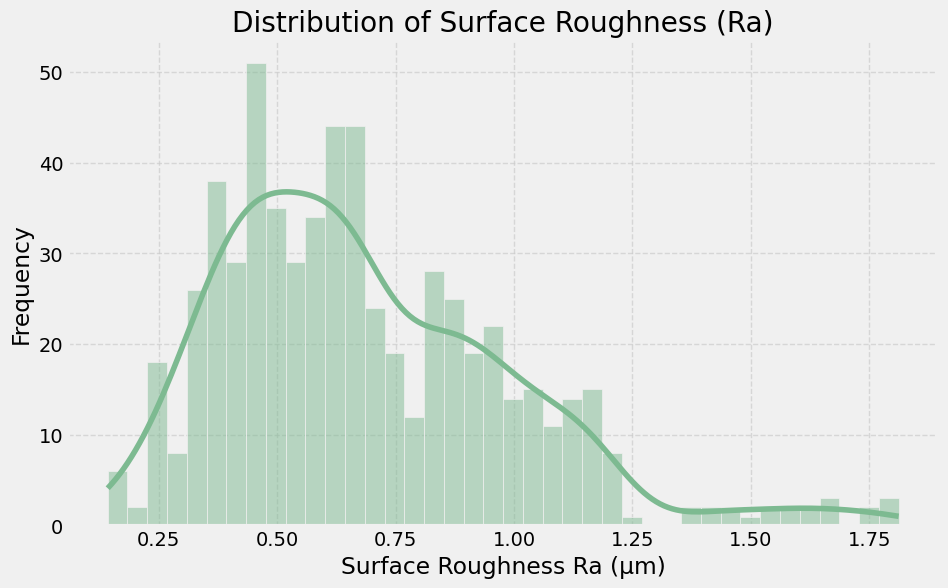

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Surface_Roughness_Ra'], kde=True, bins=40)
plt.title('Distribution of Surface Roughness (Ra)')
plt.xlabel('Surface Roughness Ra (µm)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Key Observations
Most the values fall between ~0.4 and ~0.8 μm. Which means our model may be able to predict well within that range but might struggle anywhere.

there is a right-skewed distribution, this can affect regression models that assume a normal distribution and might lead to biased predictions or overemphasis on outliers unless addressed.
<br><br><br><br>

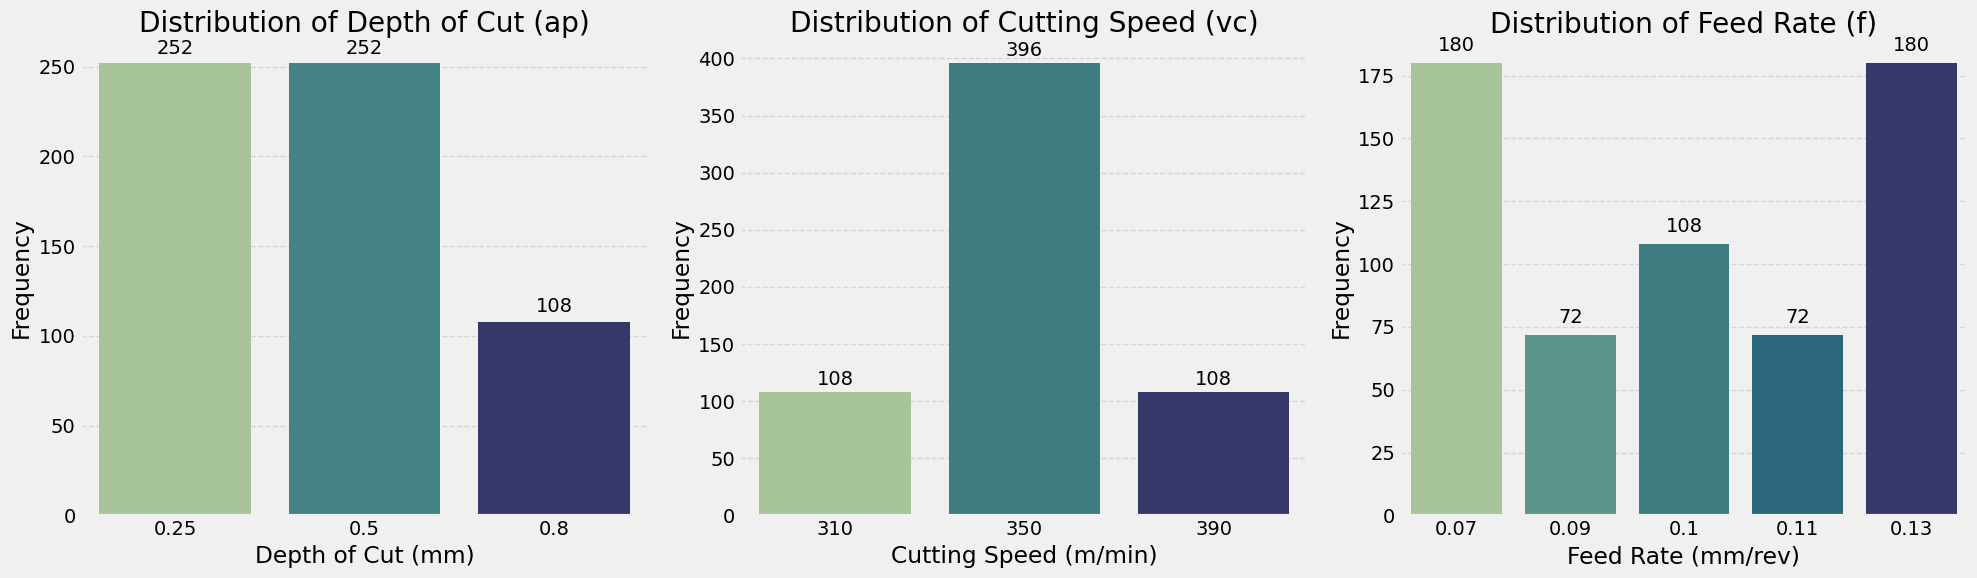

In [118]:
# --- Univariate Analysis: Count Plots for Discrete Parameters with Counts ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loop through each parameter to create its count plot and add counts
parameters = ['Depth_of_Cut_ap', 'Cutting_Speed_vc', 'Feed_Rate_f']
x_labels = ['Depth of Cut (mm)', 'Cutting Speed (m/min)', 'Feed Rate (mm/rev)']
titles = ['Distribution of Depth of Cut (ap)', 'Distribution of Cutting Speed (vc)', 'Distribution of Feed Rate (f)']

for i, param in enumerate(parameters):
    ax = axes[i]
    sns.countplot(x=param, data=merged_df, ax=ax, palette='crest',hue=param, legend=False)
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    # Add count labels on top of each bar
    for container in ax.containers: 
        for patch in container.patches:
            height = patch.get_height()
            ax.text(patch.get_x() + patch.get_width() / 2., 
                    height + 3, f'{int(height)}', 
                    ha='center', va='bottom') 

plt.tight_layout()
plt.show()

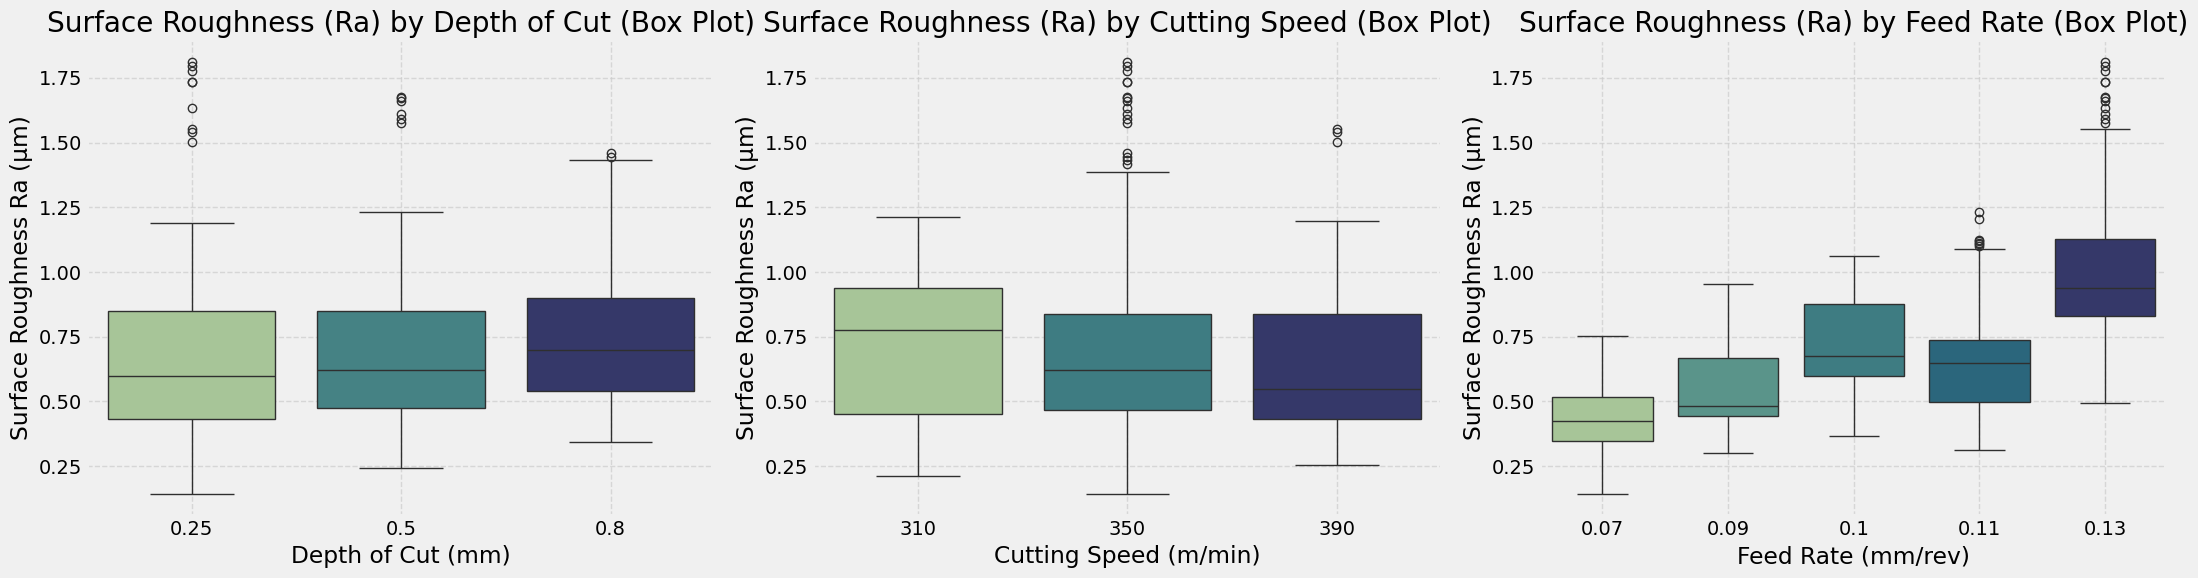

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Box Plot
sns.boxplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut (Box Plot)')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Box Plot
sns.boxplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed (Box Plot)')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Feed Rate with Box Plot
sns.boxplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2], hue='Feed_Rate_f', palette='crest', legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate (Box Plot)')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

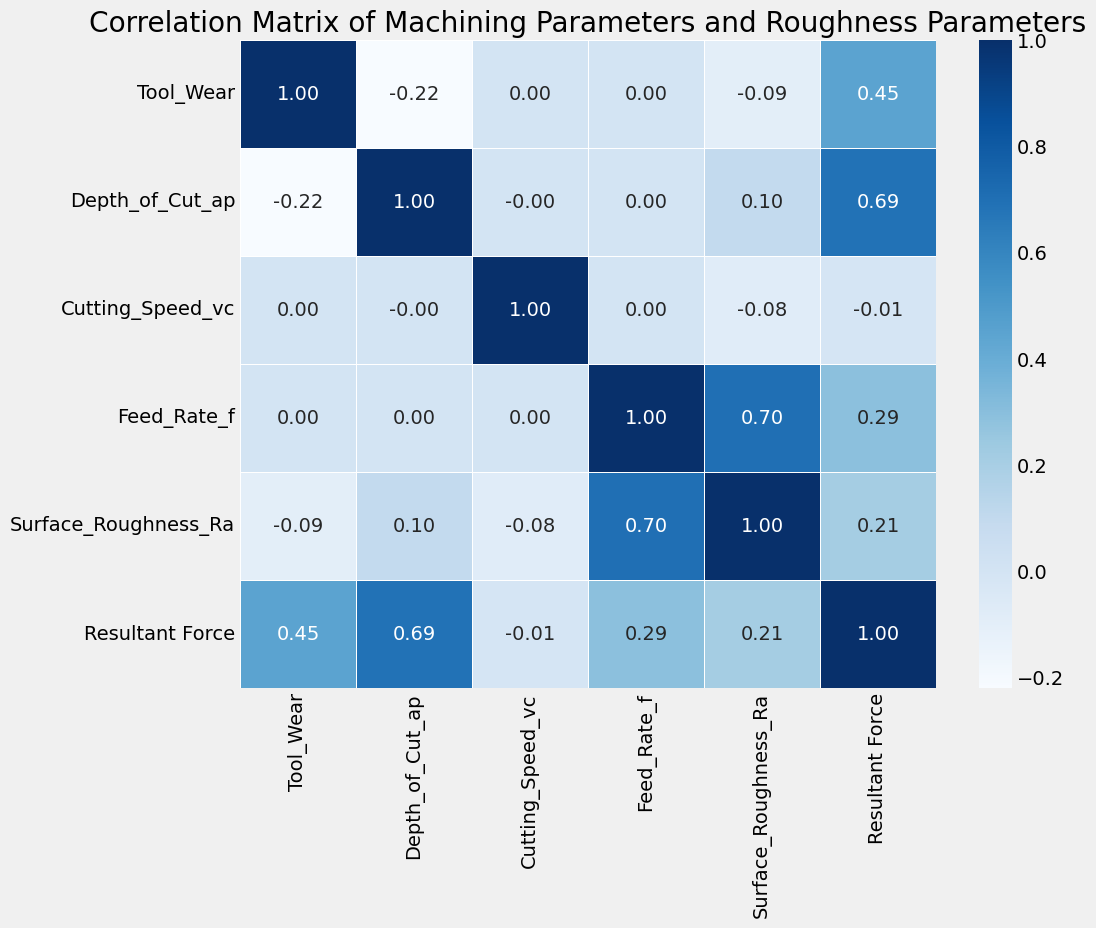

In [120]:
#Correlation Analysis
plt.figure(figsize=(10, 8))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Machining Parameters and Roughness Parameters')
plt.show()

### Correlation Matrix Key Observations:

- Feed Rate (f) is the most influential parameter, showing a direct positive relationship with Surface_Roughness_Ra. This is a critical insight for process control.
- Depth of Cut (ap) and Cutting Speed (vc) appears to have a less direct impact compared to Fx and feed rate
  <br><br><br><br>

### Data Saving 

In [121]:
merged_df.to_csv(f'{base_dir}/data/processed/cleaned_data.csv', index=False)



**EDA Summary :**

`Feed_Rate_f` is the most influential parameter to determine `Surface_Roughness_Ra` with `Cutting_Speed_vc` and `Depth_of_Cut_ap` minimal correlation.


<br><br><br><br><br>



<h2><strong>Modeling / Machine Learning</strong></h2>

`XGBoost(Extreme Gradient Boosting)` and `Random Forest` are both ensemble machine learning algorithms that utilize decision trees as their base learners, but they differ significantly in their approach to building and combining these trees.


<strong>Random Forest:<span style="margin-left: 400px;"></span>XGBoost :</strong>

Builds lots of trees independently. <span style="margin-left: 290px;"></span>Builds trees sequentially, one at a time.

Each tree sees a random subset of data and features.<span style="margin-left: 178px;">Each new tree tries to fix the errors of the previous one.

Final prediction: regression or classification<span style="margin-left: 239px;">Final prediction: weighted combination of all trees.



In [122]:
#base_dir = r"C:\Users\santo\OneDrive\Documents\GitHub\Surface_Roughness"
merged_df = pd.read_csv(f"{base_dir}/data/processed/cleaned_data.csv")

In [123]:
# Define the target variable
target_column = 'Surface_Roughness_Ra'
y = merged_df[target_column]



# Drop the target column to get the feature matrix
X = merged_df.drop(columns=[target_column]).copy()

print(f"Target variable '{target_column}' defined. Shape: {y.shape}")
print(f"Initial features (X) defined. Shape: {X.shape}")
print("\nFirst 5 rows of X:")
X.head()

Target variable 'Surface_Roughness_Ra' defined. Shape: (612,)
Initial features (X) defined. Shape: (612, 5)

First 5 rows of X:


,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Resultant Force
0,0.0,0.25,350,0.07,69.600499
1,0.0,0.25,350,0.07,69.600499
2,0.0,0.25,350,0.07,69.600499
3,0.0,0.25,350,0.07,69.600499
4,0.0,0.25,350,0.07,69.600499


### Data Scaling

Scaling numerical features is a critical preprocessing step for many machine learning algorithms. While tree-based models (like Random Forest and XGBoost, which we plan to use) are less sensitive to feature scales, scaling is good practice for:


In [124]:
print("\nScaling numerical features using StandardScaler...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to X and transform X
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back to a DataFrame, preserving column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


X_scaled_df.head()


Scaling numerical features using StandardScaler...


,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Resultant Force
0,-0.57886,-1.011215,0.0,-1.275798,-1.338158
1,-0.57886,-1.011215,0.0,-1.275798,-1.338158
2,-0.57886,-1.011215,0.0,-1.275798,-1.338158
3,-0.57886,-1.011215,0.0,-1.275798,-1.338158
4,-0.57886,-1.011215,0.0,-1.275798,-1.338158


In [125]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation for Multiple Models

In [126]:
results = []

# Models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'SupportVectorRegression': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma='scale'))
}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })

results_df = pd.DataFrame(results)





--- Training and Evaluating RandomForestRegressor ---

--- Training and Evaluating XGBoostRegressor ---

--- Training and Evaluating KNeighborsRegressor ---

--- Training and Evaluating SupportVectorRegression ---


In [127]:
results_df = results_df.reset_index(drop=True)
results_df

,Model,MAE,MSE,RMSE,MAPE,R^2
0,RandomForestRegressor,0.032403,0.003203,0.056598,0.046747,0.968229
1,XGBoostRegressor,0.032181,0.003127,0.055917,0.046265,0.968989
2,KNeighborsRegressor,0.070930,0.010207,0.101027,0.103738,0.898771
3,SupportVectorRegression,0.109025,0.022363,0.149542,0.178623,0.778202


* **MAE (Mean Absolute Error):** Average size of errors.


* **MSE (Mean Squared Error):** Penalizes larger errors more.
* **RMSE (Root Mean Squared Error):** how far off your predictions usually are from the real values but in the same units as what you’re predicting.
* **MAPE (Mean Absolute Percentage Error):** Average error as a percentage.
* **R² (Coefficient of Determination):** How much variance is explained, where R² = 1 → perfect predictions

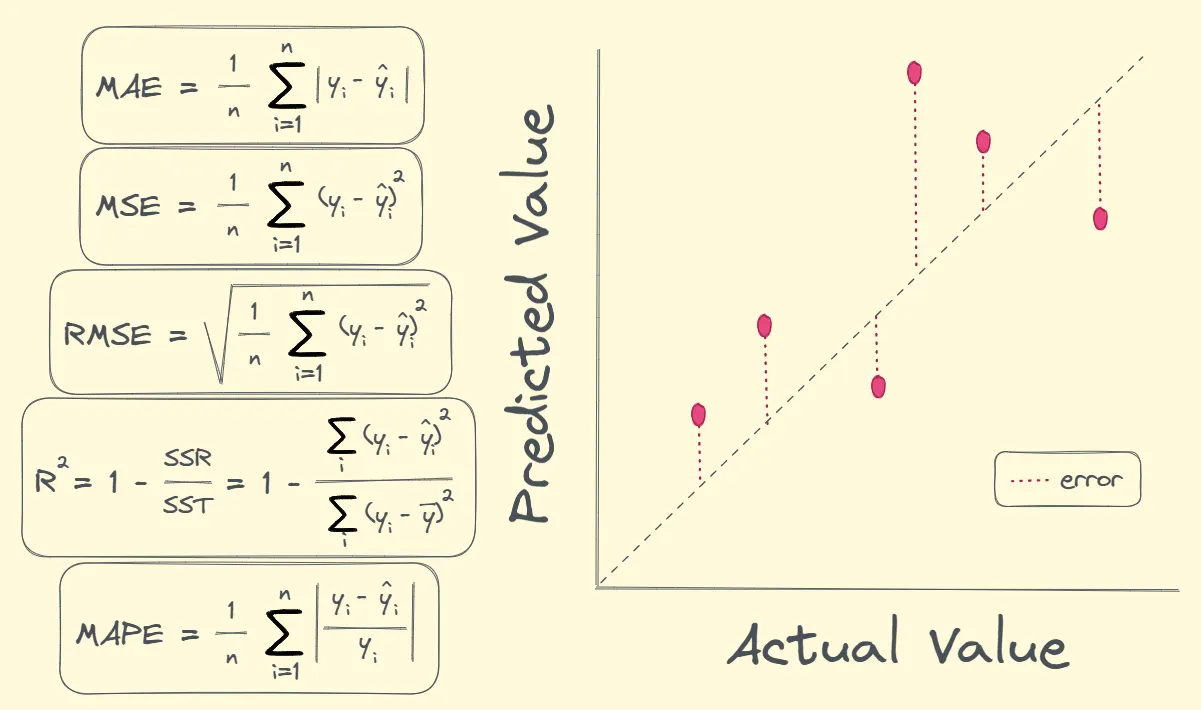

In [128]:
display(Image(filename=f"{base_dir}/images/eval.webp", width=800))

In [129]:
new_results = []
trained_models = {}

# Models with their parameter grids
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': list(range(1, 11)),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
     'SupportVectorRegression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(kernel='rbf'))
        ]),
        'param_grid': {
            'svr__C': [1, 10, 100, 200],
            'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
            'svr__gamma': ['scale', 0.01, 0.1, 0.5]
        }}
}


for name, model_info in models.items():
    print(f"\n--- Grid Search for {name} ---")
    model = model_info['model']
    param_grid = model_info['param_grid']

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"{name} best params: {grid_search.best_params_}")

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    new_results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })
    trained_models[name] = best_model
new_results_df = pd.DataFrame(new_results)



--- Grid Search for RandomForestRegressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
RandomForestRegressor best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

--- Grid Search for XGBoostRegressor ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoostRegressor best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}

--- Grid Search for KNeighborsRegressor ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
KNeighborsRegressor best params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

--- Grid Search for SupportVectorRegression ---
Fitting 5 folds for each of 64 candidates, totalling 320 fits
SupportVectorRegression best params: {'svr__C': 200, 'svr__epsilon': 0.01, 'svr__gamma': 0.5}


In [130]:
new_results_df['old_R^2'] = results_df['R^2']


In [131]:
new_results_df

,Model,Best Params,MAE,MSE,RMSE,MAPE,R^2,old_R^2
0,RandomForestRegressor,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.032492,0.003169,0.056290,0.046379,0.968574,0.968229
1,XGBoostRegressor,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",0.032841,0.003161,0.056225,0.047725,0.968646,0.968989
2,KNeighborsRegressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.031973,0.003113,0.055792,0.045867,0.969127,0.898771
3,SupportVectorRegression,"{'svr__C': 200, 'svr__epsilon': 0.01, 'svr__ga...",0.070247,0.017103,0.130778,0.106846,0.830371,0.778202



--- Feature Importance for RandomForestRegressor ---


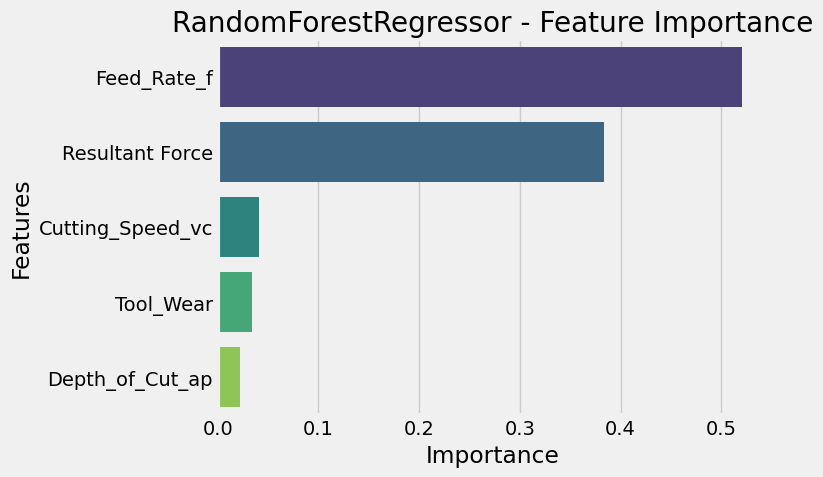


--- Feature Importance for XGBoostRegressor ---


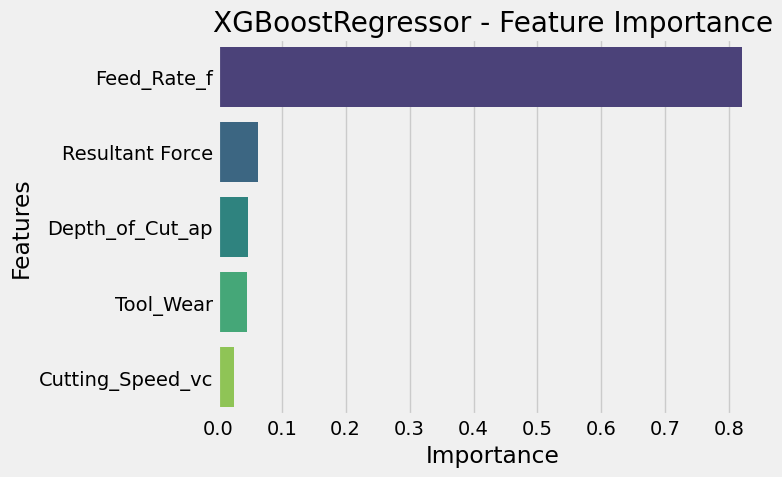


--- Feature Importance for KNeighborsRegressor ---


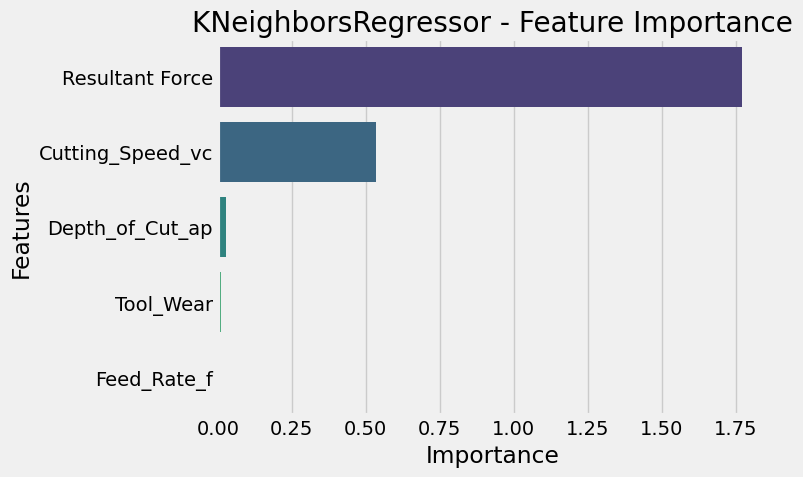


--- Feature Importance for SupportVectorRegression ---


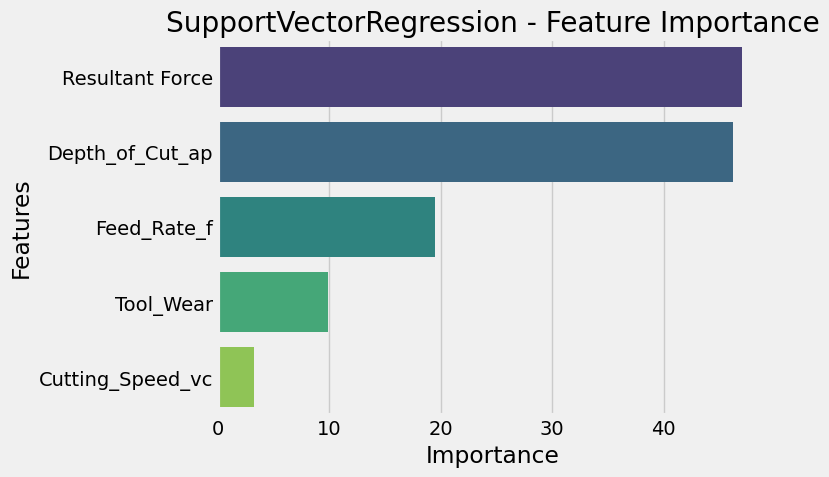

In [132]:
# ---Feature importance plotting ---
for name, model in trained_models.items():
    print(f"\n--- Feature Importance for {name} ---")

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps'): 
        step = list(model.named_steps.values())[-1] 
        if hasattr(step, 'feature_importances_'):
            importances = step.feature_importances_
        else:  # permutation importance for non-tree models
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
            importances = result.importances_mean
    else:
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    features = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]

    # Sort importances from high to low
    importances = np.array(importances)
    features = np.array(features)
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = features[sorted_idx]

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
    plt.title(f"{name} - Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


<strong>Purpose:</strong>
     
    - Visualize how close your predictions are to the actual values.

    - Ideally, all points should fall close to the diagonal line y = x.

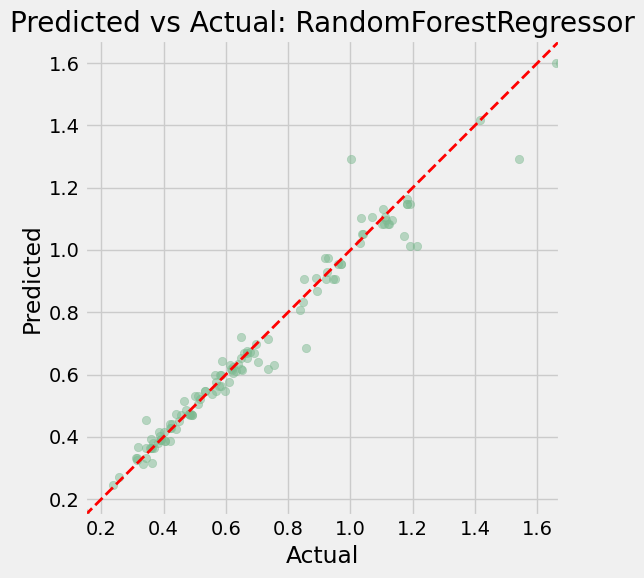

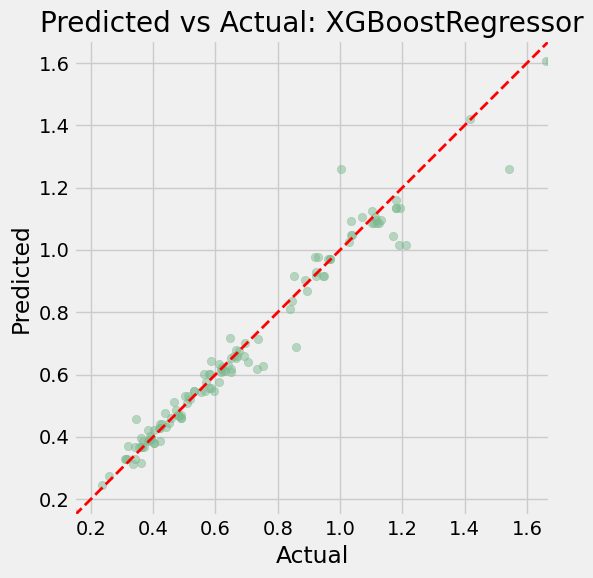

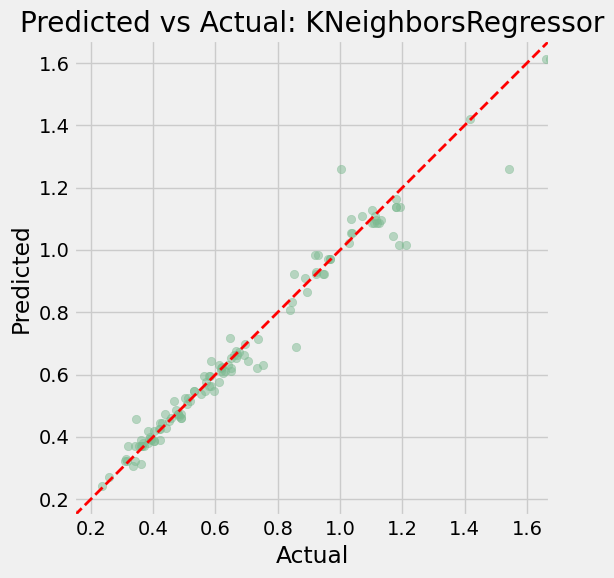

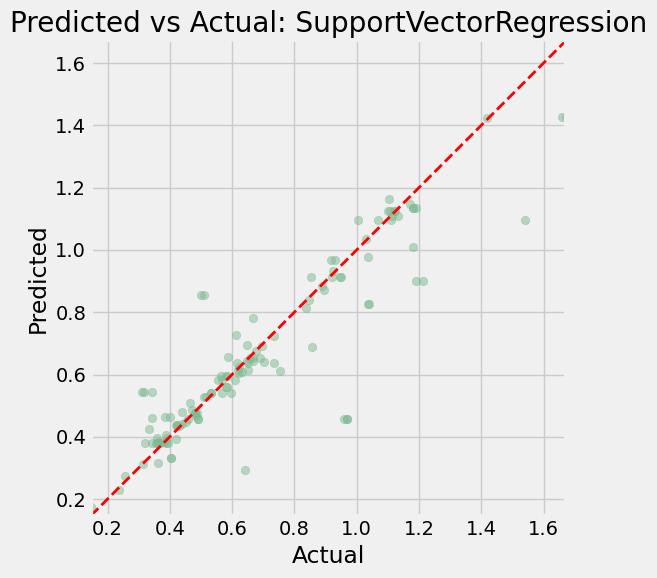

In [133]:
# Predicted vs Actual plots
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]

    # scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot(lims, lims, 'r--', lw=2)  # perfect prediction line
    plt.xlim(lims)
    plt.ylim(lims)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual: {name}")
    plt.tight_layout()
    plt.show()


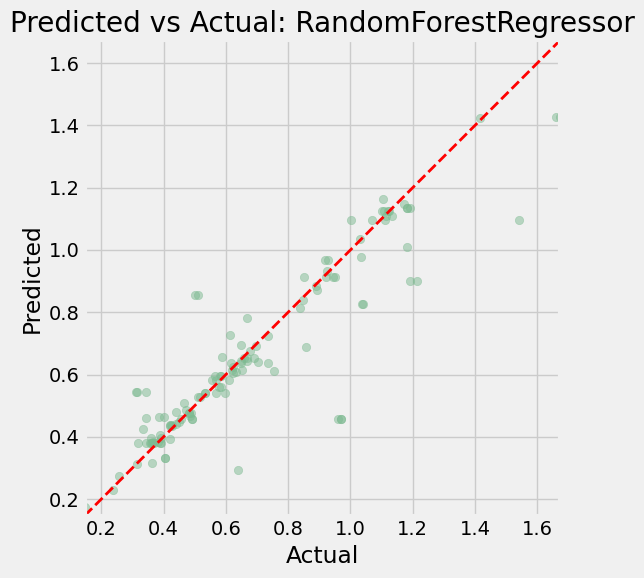

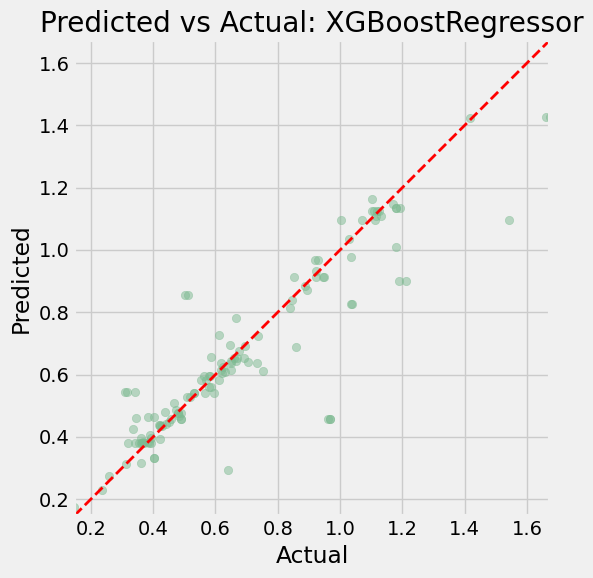

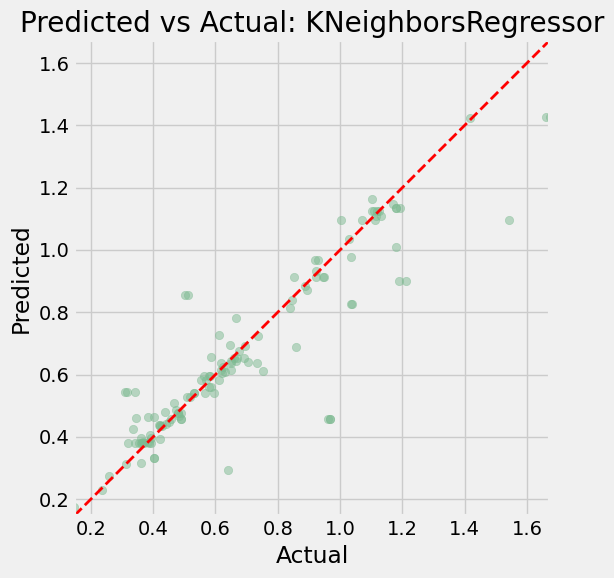

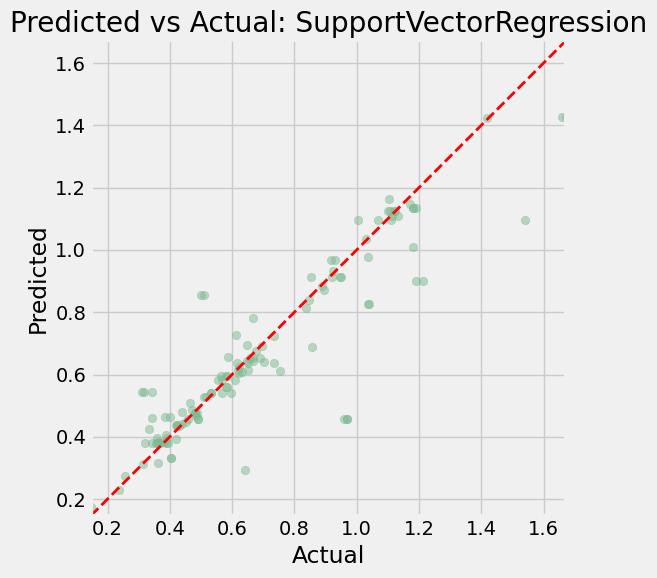

In [134]:

    for name, model in models.items():
        lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot(lims, lims, 'r--', lw=2)
        plt.xlim(lims); plt.ylim(lims)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Predicted vs Actual: {name}")
        plt.tight_layout()
        plt.show()


## Dropping Force Reading from Dataset

In [135]:
X_train

,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Resultant Force
561,0.3,0.25,350,0.13,238.512340
287,0.0,0.80,310,0.13,377.572513
322,0.0,0.80,390,0.10,334.640671
132,0.0,0.80,390,0.10,299.365351
174,0.0,0.25,350,0.07,72.052198
...,...,...,...,...,...
71,0.0,0.50,310,0.10,171.479524
106,0.0,0.50,350,0.07,134.202319
270,0.0,0.80,310,0.10,328.671630
435,0.1,0.25,350,0.07,116.475599


In [ ]:
X_train = X_train.drop(columns=['Resultant Force'])
X_test = X_test.drop(columns=['Resultant Force'])

In [141]:
n_results = []

# Models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'SupportVectorRegression': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma='scale'))
}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    n_results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })

n_results_df = pd.DataFrame(n_results)


--- Training and Evaluating RandomForestRegressor ---

--- Training and Evaluating XGBoostRegressor ---

--- Training and Evaluating KNeighborsRegressor ---

--- Training and Evaluating SupportVectorRegression ---


In [142]:
n_results_df

,Model,MAE,MSE,RMSE,MAPE,R^2
0,RandomForestRegressor,0.101957,0.021992,0.148297,0.166880,0.781880
1,XGBoostRegressor,0.101827,0.022002,0.148331,0.167096,0.781781
2,KNeighborsRegressor,0.108246,0.022475,0.149915,0.178789,0.777095
3,SupportVectorRegression,0.125261,0.031593,0.177745,0.200786,0.686655
